#Reading Text from PDF using Pymupdf

####Installing PymuPDF

In [ ]:
!pip install pyMupdf

####Importing Packages

In [ ]:
import fitz
import pandas as pd

#### Fuction to open the document and extract pages

In [ ]:
def read_doc():
  path = input("Please Enter the path of your Pdf file: ")
  text = fitz.open(path)
  return text 
read_doc = read_doc()

Please Enter the path of your Pdf file: /content/Extracted pages from keppel-corporation-limited-annual-report-2018.pdf


##Method 1 
#### using built-in fucntion to get the text from page and then parsed the raw data to desireable form

In [ ]:
def text_parsing_method1(doc_read):
  para = ""
  list_of_strings = []
  for page in range(doc_read.page_count):
    text = doc_read.load_page(page).get_text()
    for txt in text.split("\n"):
      if txt.endswith(".") or txt.endswith(". ") or txt.endswith("?") or txt.endswith("? "):
        para += para + " " + txt
        list_of_strings.append(para)
        para = ""
      else:
        para = para + " " + txt
    for string in list_of_strings:
      for word in string.split("\t"):
         if "\Xa0" in word:
            word.replace("\Xa0", " ")
  return list_of_strings
parsed_text_method1 = text_parsing_method1(read_doc)

##Method 2 
#### using built-in fucntion to get the word list from get_text function and the applied processing to get the word list concatenated in desired order

In [ ]:
def text_parsing_method2(doc_read):
  list_of_strings = []
  for page in range(doc_read.page_count):
    text = doc_read.load_page(page).get_text('words', flags=fitz.TEXT_PRESERVE_LIGATURES | fitz.TEXT_INHIBIT_SPACES)
    for i in range(text[-1][5]):
      list_para = []
      para = ""
      for value in text:
        if value[5] == i:
          list_para.append(value[4])
      list_of_strings.append(" ".join(list_para)) 
  for string in list_of_strings:
    if len(string) < 80:
      list_of_strings.remove(string)
        
  return list_of_strings
parsed_text_method2 = text_parsing_method2(read_doc)

#### Excel file saving function

In [ ]:
def save_excel(filename, data):
  text_dataframe = pd.DataFrame(data)
  with pd.ExcelWriter('/content/' + filename) as writer:
      text_dataframe.to_excel(writer, sheet_name='sheet1')

#### Saving Excel

In [ ]:
save_excel("Method1.xlsx", parsed_text_method1)
save_excel("Method2.xlsx", parsed_text_method2)

#Reading Text using pretrainded deep learning model Detectron2 and OCR models

#### Installing Packages and pre-trained models.

In [ ]:
!pip install -U layoutparser
!pip install -U layoutparser
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
!pip install layoutparser[ocr]

#### Reading Image, for simplicity I have used a single image here beacuse layout detection and OCR models take a lot of time to return results

In [ ]:
import cv2
bgr_image = cv2.imread("/content/Extracted pages from keppel-corporation-limited-annual-report-2018-3.jpg")
rgb_image = bgr_image[..., ::-1]
# Because CV by default loads image in BGR array, therefor we are converting it to RGB because Detectron 2 accepts RGB array

#### Model Defination and drawing bounding boxes around all entities

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


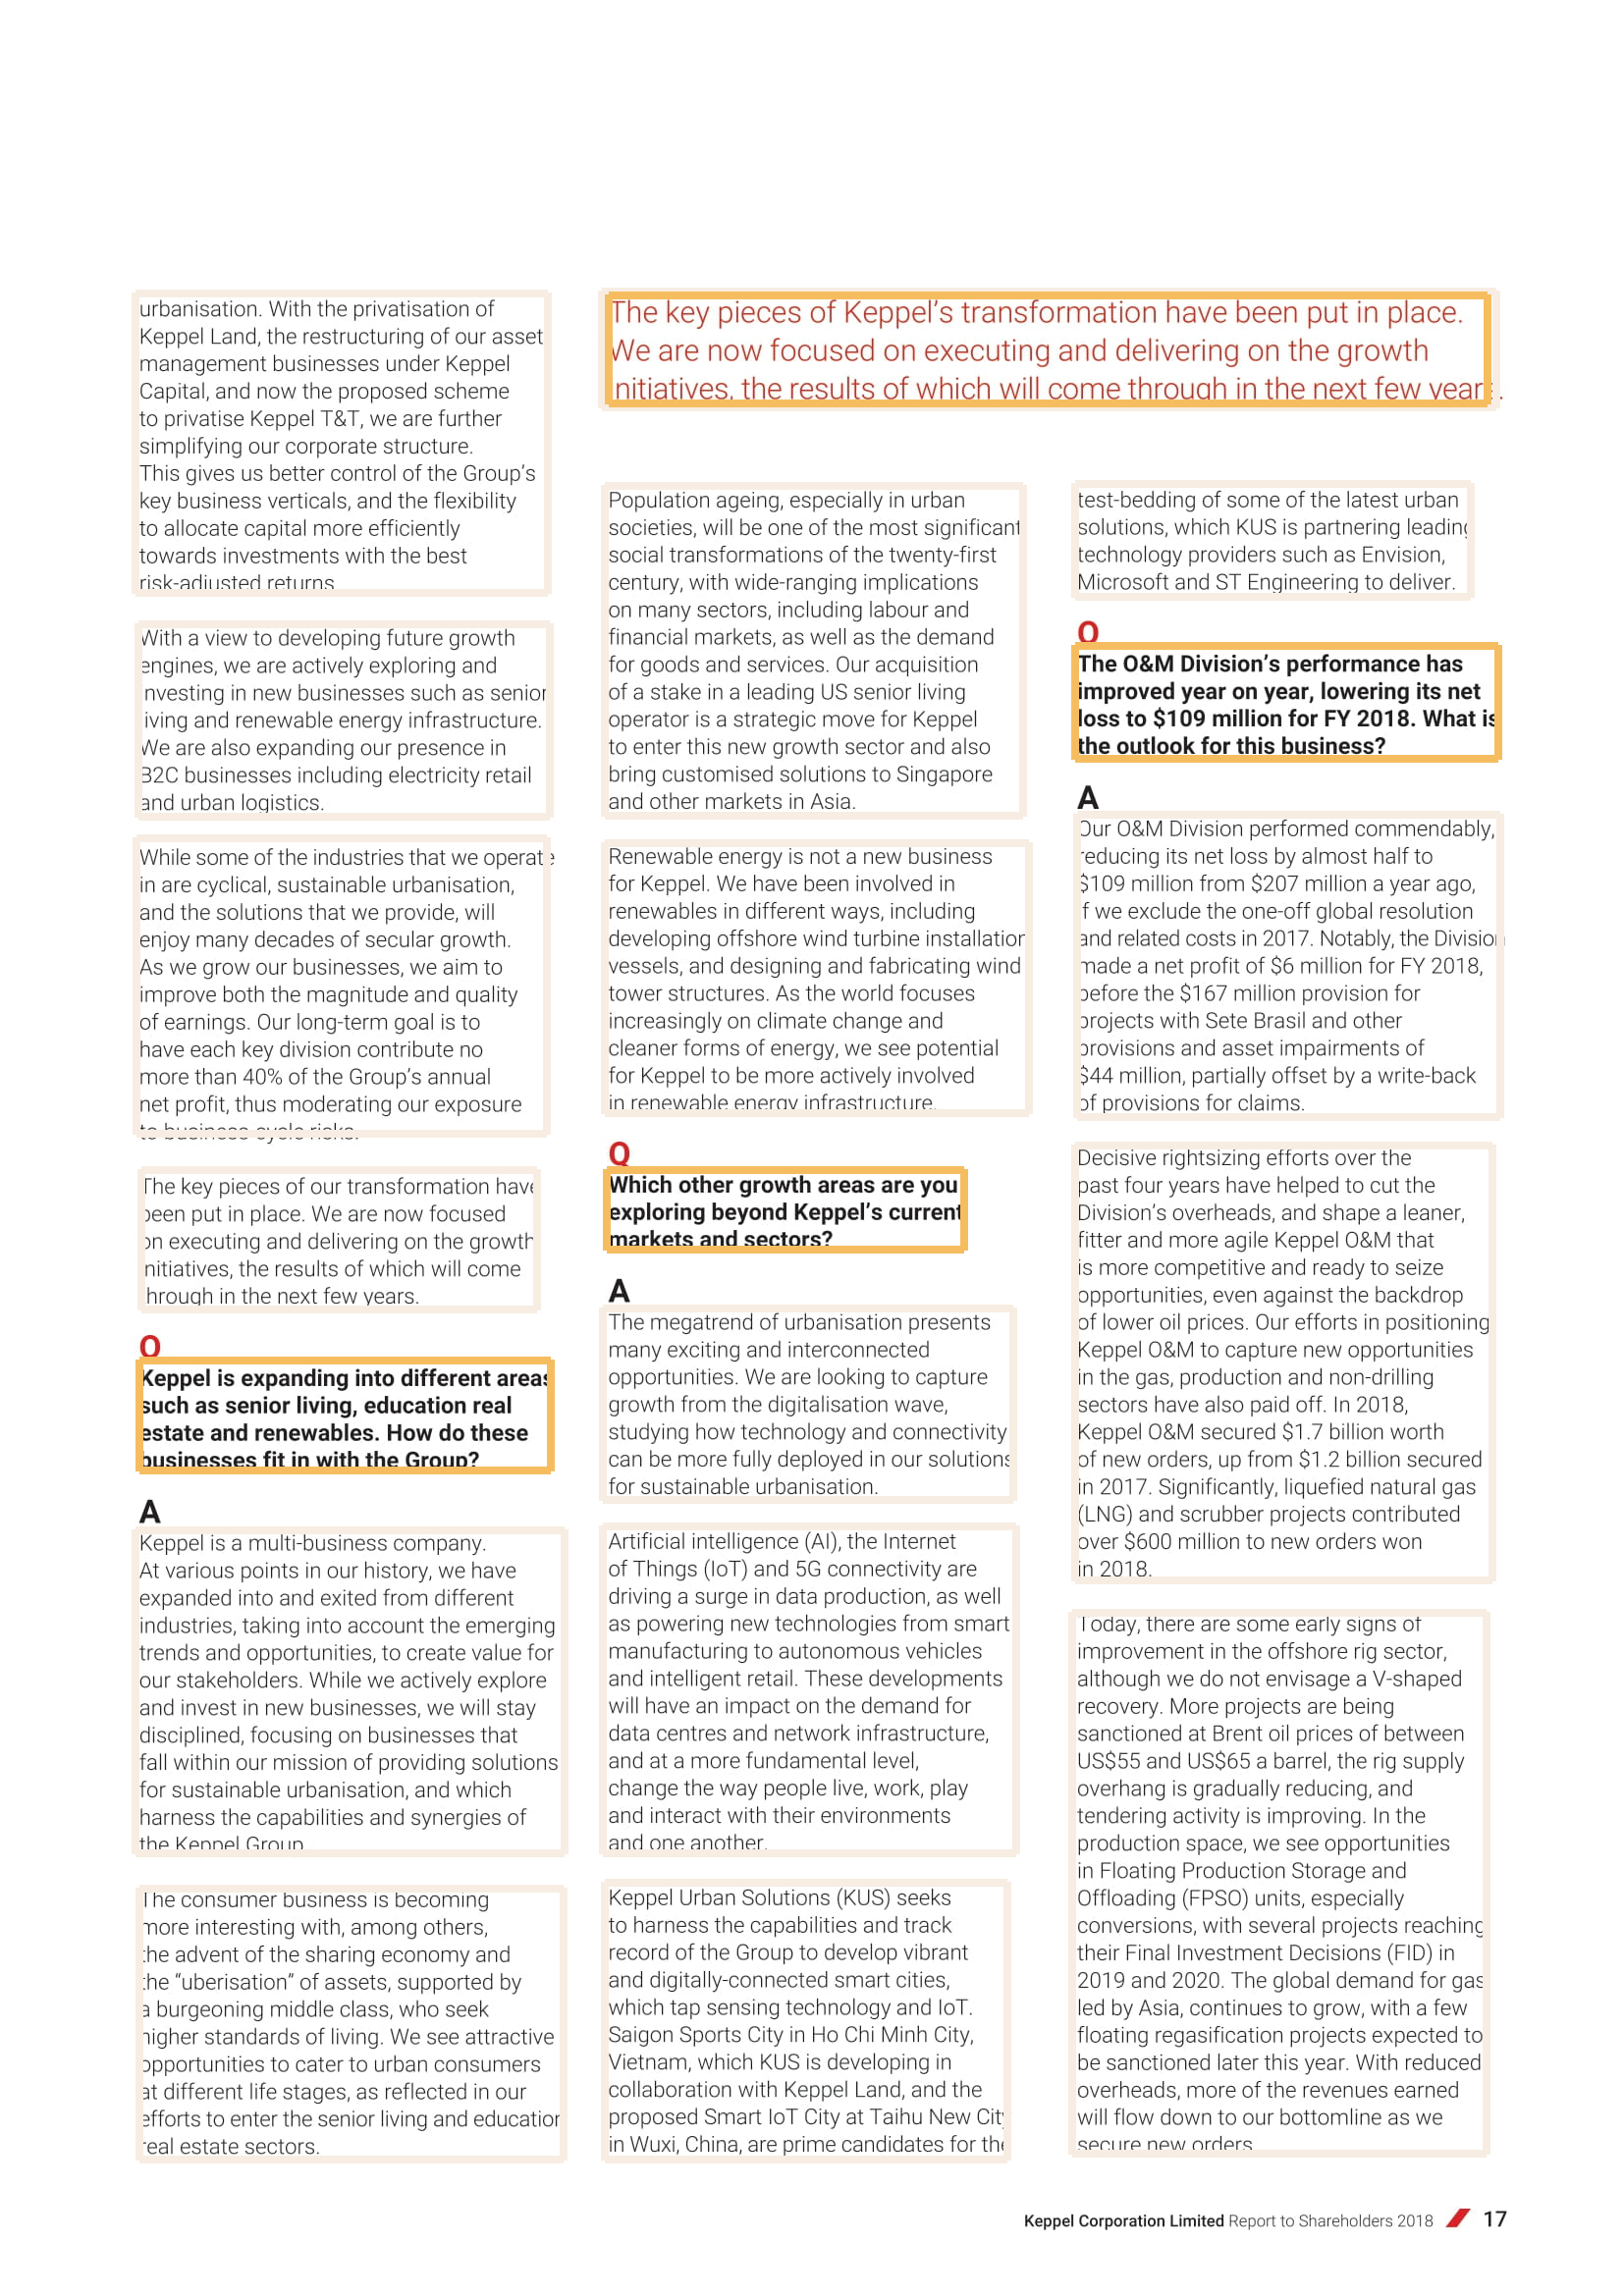

In [ ]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
# 'lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config'is our pretrained model and we are giving 0.65 confidence score for the bounding box to 
# be drawn around our regions of interest
# The label_map are the labels that this model is trained to detect.
extracted_layout = model.detect(rgb_image) 
lp.draw_box(rgb_image, extracted_layout,)

#### Filtering only text bounding boxes

In [ ]:
text_bounding_boxes = lp.Layout([b for b in extracted_layout if b.type=="Text" ])

#### Sorting bounding boxes according to columns

In [ ]:
h, w = rgb_image.shape[:2]
def divide_columns(w, bounding_boxes):
  left_column = lp.Interval(0, w/3*1.05, axis='x').put_on_canvas(rgb_image)
  mid_column = lp.Interval(w/3*1.05, 2*w/3*1.05, axis='x').put_on_canvas(rgb_image)
  left_column_boxes = bounding_boxes.filter_by(left_column, center=True)
  left_column_boxes.sort(key = lambda b:b.coordinates[1])
  mid_column_boxes = bounding_boxes.filter_by(mid_column, center=True)
  mid_column_boxes.sort(key = lambda b:b.coordinates[1])
  right_column_boxes = [b for b in bounding_boxes if b not in left_column_boxes and mid_column_boxes]
  right_column_boxes.sort(key = lambda b:b.coordinates[1])
  sorted_bounding_boxes = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_column_boxes + mid_column_boxes + right_column_boxes)])
  return sorted_bounding_boxes

In [ ]:
sorted_bounded_boxes = divide_columns(w, text_bounding_boxes)

#### Drawing sorted bounded boxes. I doesn't work as required but given more time I could make it work

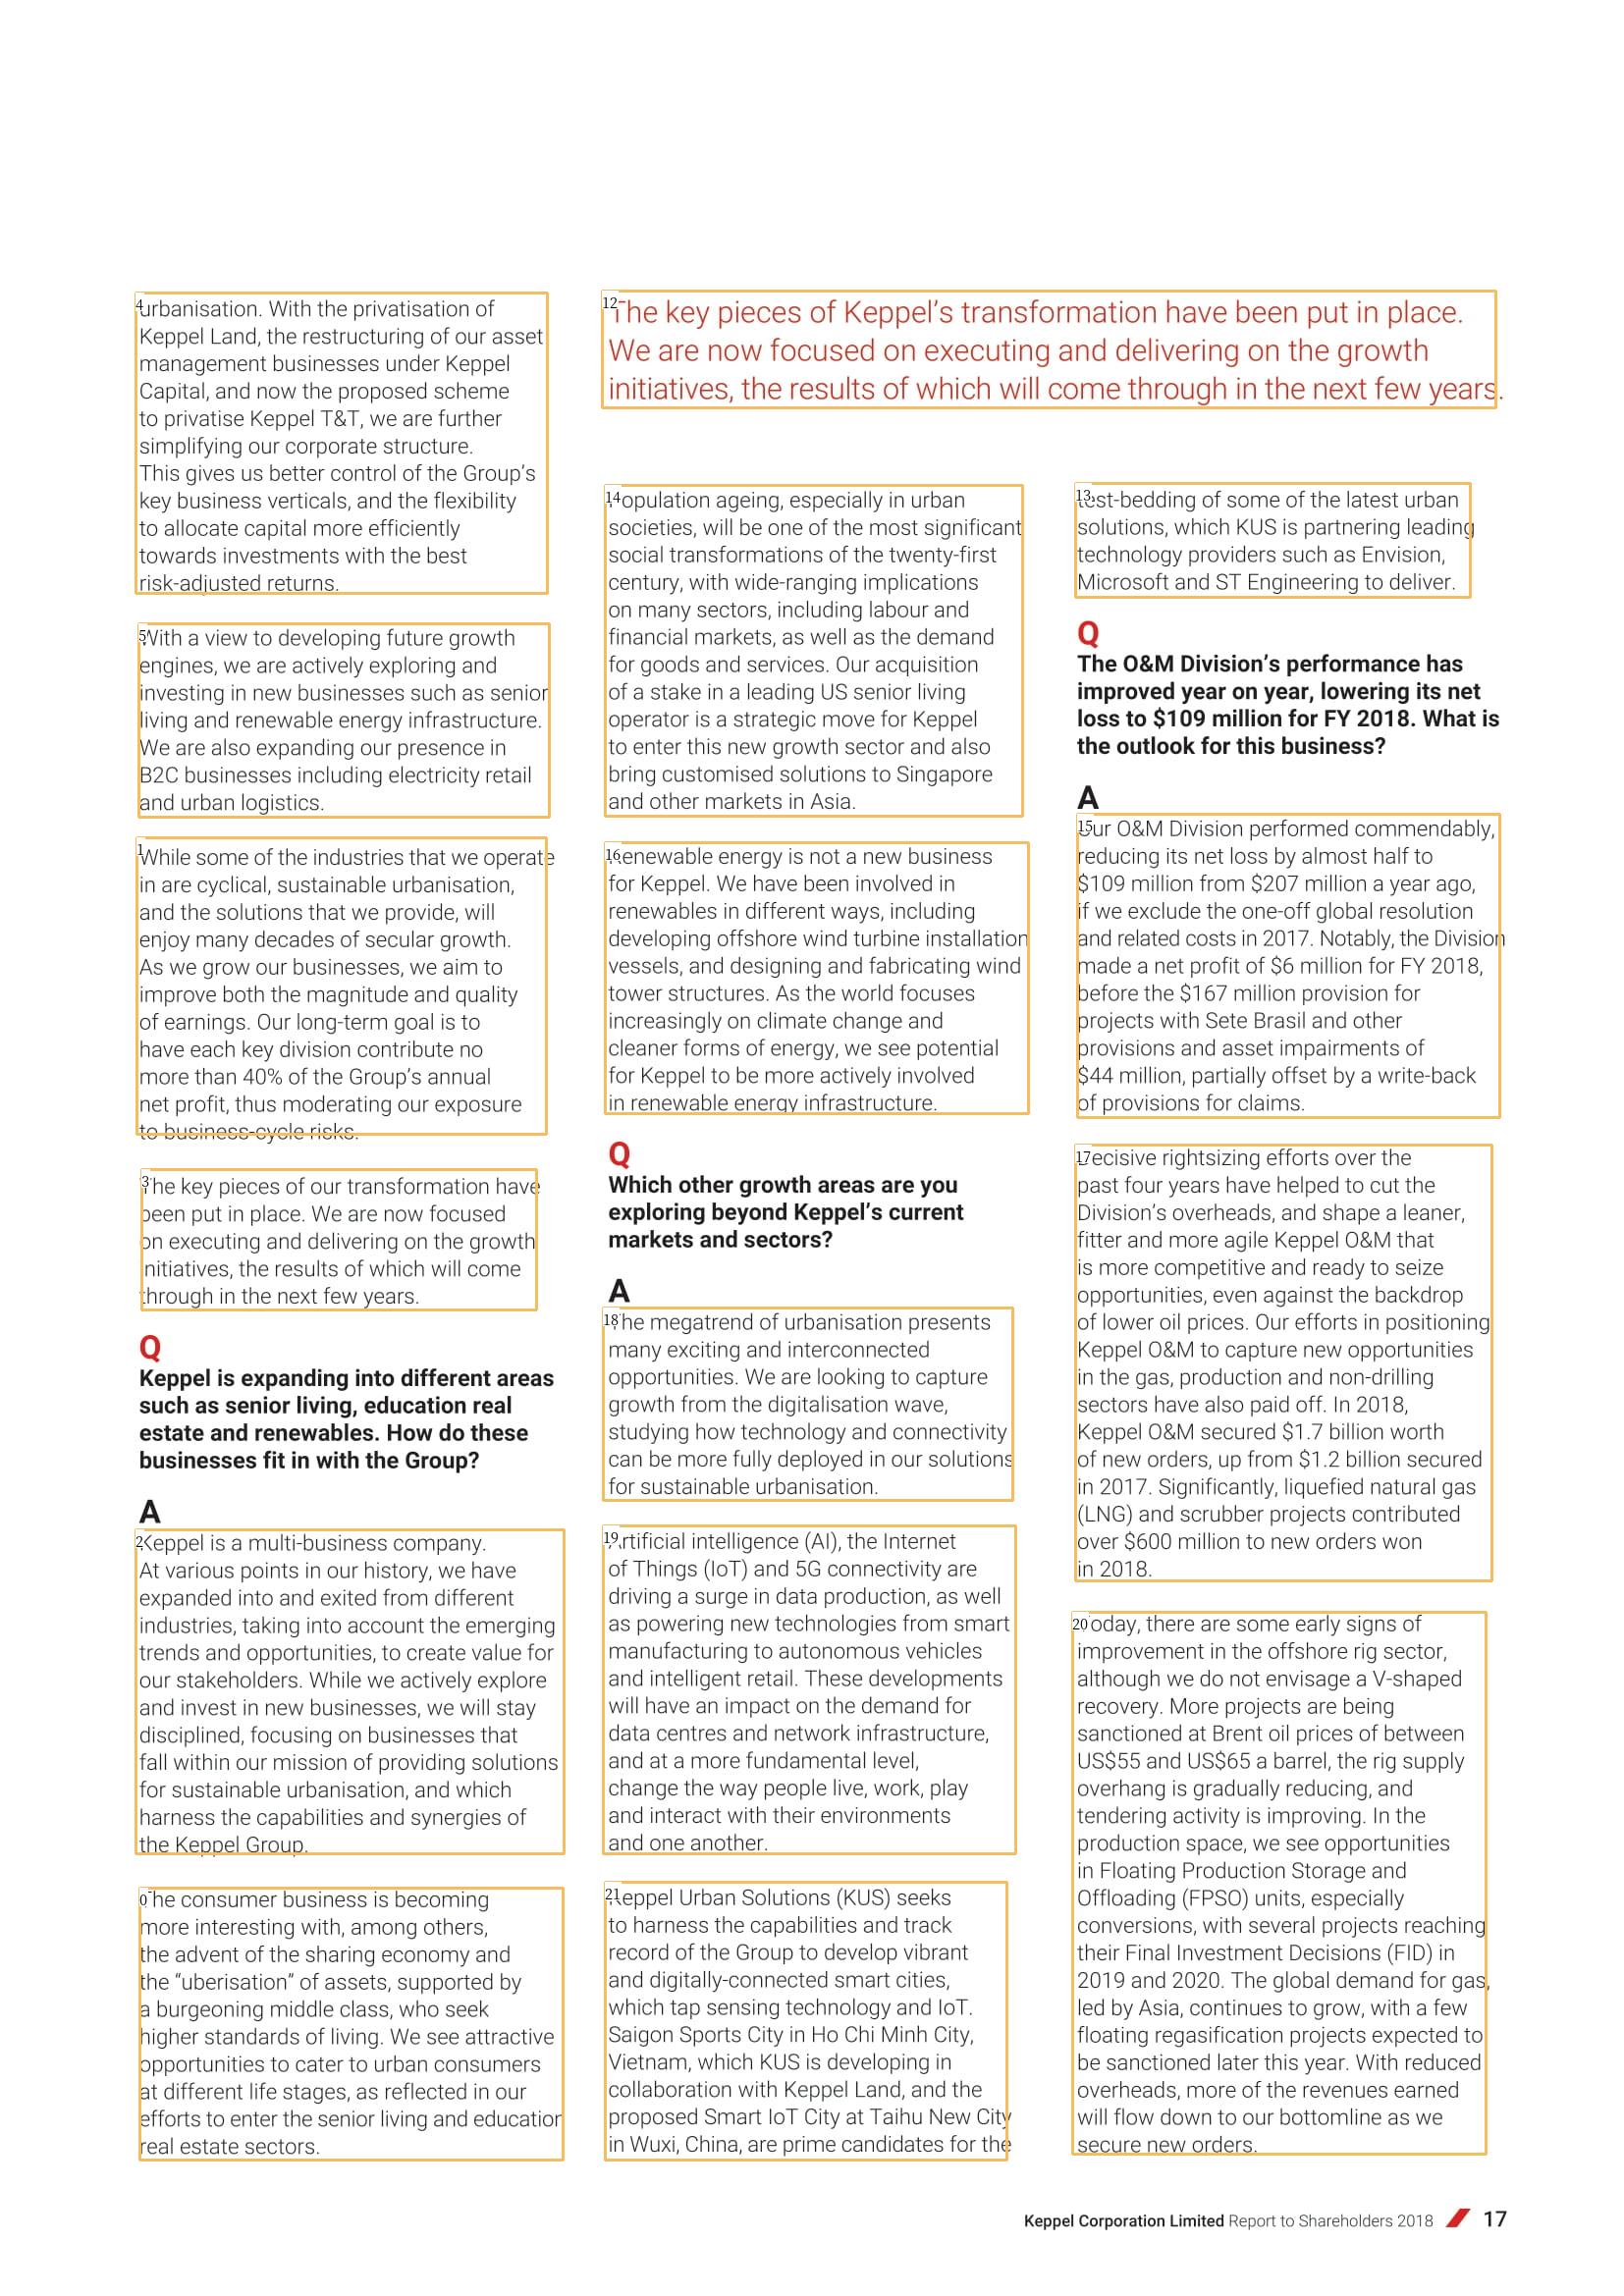

In [ ]:
lp.draw_box(rgb_image, sorted_bounded_boxes,
            box_width=3, 
            show_element_id=True)

### Initializing OCR Model

In [ ]:
ocr_reader = lp.TesseractAgent(languages='eng') 

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


### Extracting text form the bounding boxes using pre-trained OCR model

In [ ]:
for block in sorted_bounded_boxes:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(rgb_image))
        
    text = ocr_reader.detect(segment_image)
    block.set(text=text, inplace=True)

#### Saving in excel file

In [ ]:
list_of_data = []
for txt in sorted_bounded_boxes.get_texts():
   txt.replace("\n", " ")
   list_of_data.append(txt)
   

In [ ]:
save_excel("Method3.xlsx", list_of_data)